Data source - https://www.hse.ru/rlms/spss2

In [1]:
import pandas as pd
import numpy as np
import pyreadstat # for expansion "sav"
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from imblearn.over_sampling import SMOTE
from matplotlib.pyplot import figure
import graphviz, sklearn, shap
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, classification_report, 
                             accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import (get_roc_curve, 
                            get_fnr_curve, 
                            get_fpr_curve)
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from catboost.utils import select_threshold
shap.initjs() #for visualization
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versi

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
%%time
df, meta = pyreadstat.read_sav('RLMS_IND_1994_2021_2022_08_21_1_v3_rus.sav') # Loading our file
df.shape

CPU times: user 20.2 s, sys: 3.48 s, total: 23.7 s
Wall time: 25.2 s


(407191, 2775)

In [4]:
employment = df[['year', 'idind', 'region', 'marst', 'diplom', 'age', 'h5',
       'j1.1.2', 'j1.1.3', 'j1.1.4', 'j4.1', 'j5a', 'j6', 'j6.2', 'j7.1',
       'j10', 'j10.3', 'j11.1', 'j13', 'j14', 'j21b',
       'j21.3', 'j23', 'j24', 'j25', 'j22', 'j31', 'j32.1', 'j73',
       'j200', 'm20.7', 'l5.0', 'j18.2']]

<Axes: >

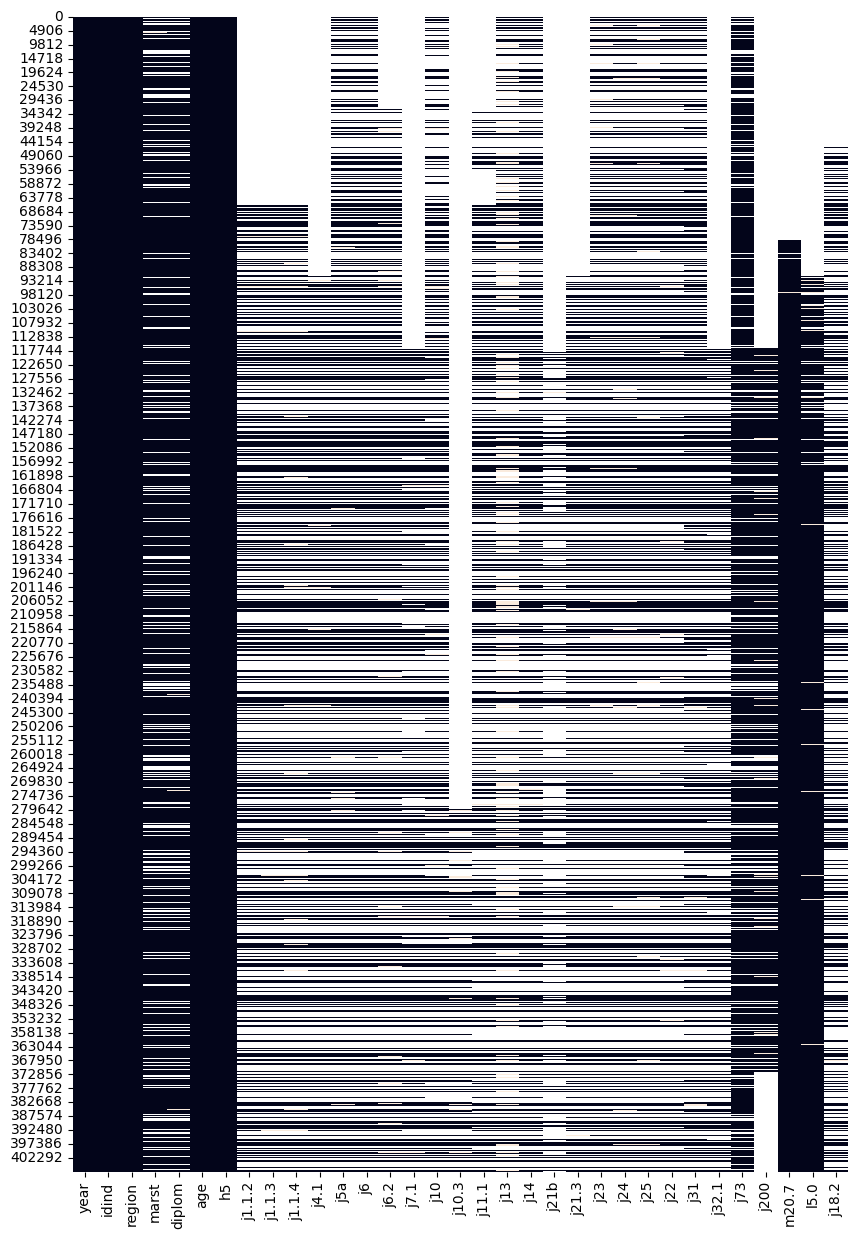

In [5]:
# Visualization forgiven values
figure(figsize = (10, 15))
sns.heatmap(employment, cbar=False)

In [6]:
employment = employment[employment['j10.3'].notna()]

employment.replace(99999995.0, np.nan, inplace=True)
employment.replace(99999996.0, np.nan, inplace=True)
employment.replace(99999997.0, np.nan, inplace=True)
employment.replace(99999998.0, np.nan, inplace=True)
employment.replace(99999999.0, np.nan, inplace=True)

employment = employment[employment['j10.3'].notna()]
employment.rename(columns={'j10.3': 'type_of_salary'}, inplace=True)
employment = employment.dropna()
employment.type_of_salary.value_counts()

# Rename values in "Type_of_salary" to classic "0" and "1"
employment['type_of_salary'].replace(1, 0, inplace=True)
employment['type_of_salary'].replace(2, 1, inplace=True)

final_df = employment[employment['type_of_salary'] < 3]

Text(0.5, 0, '')

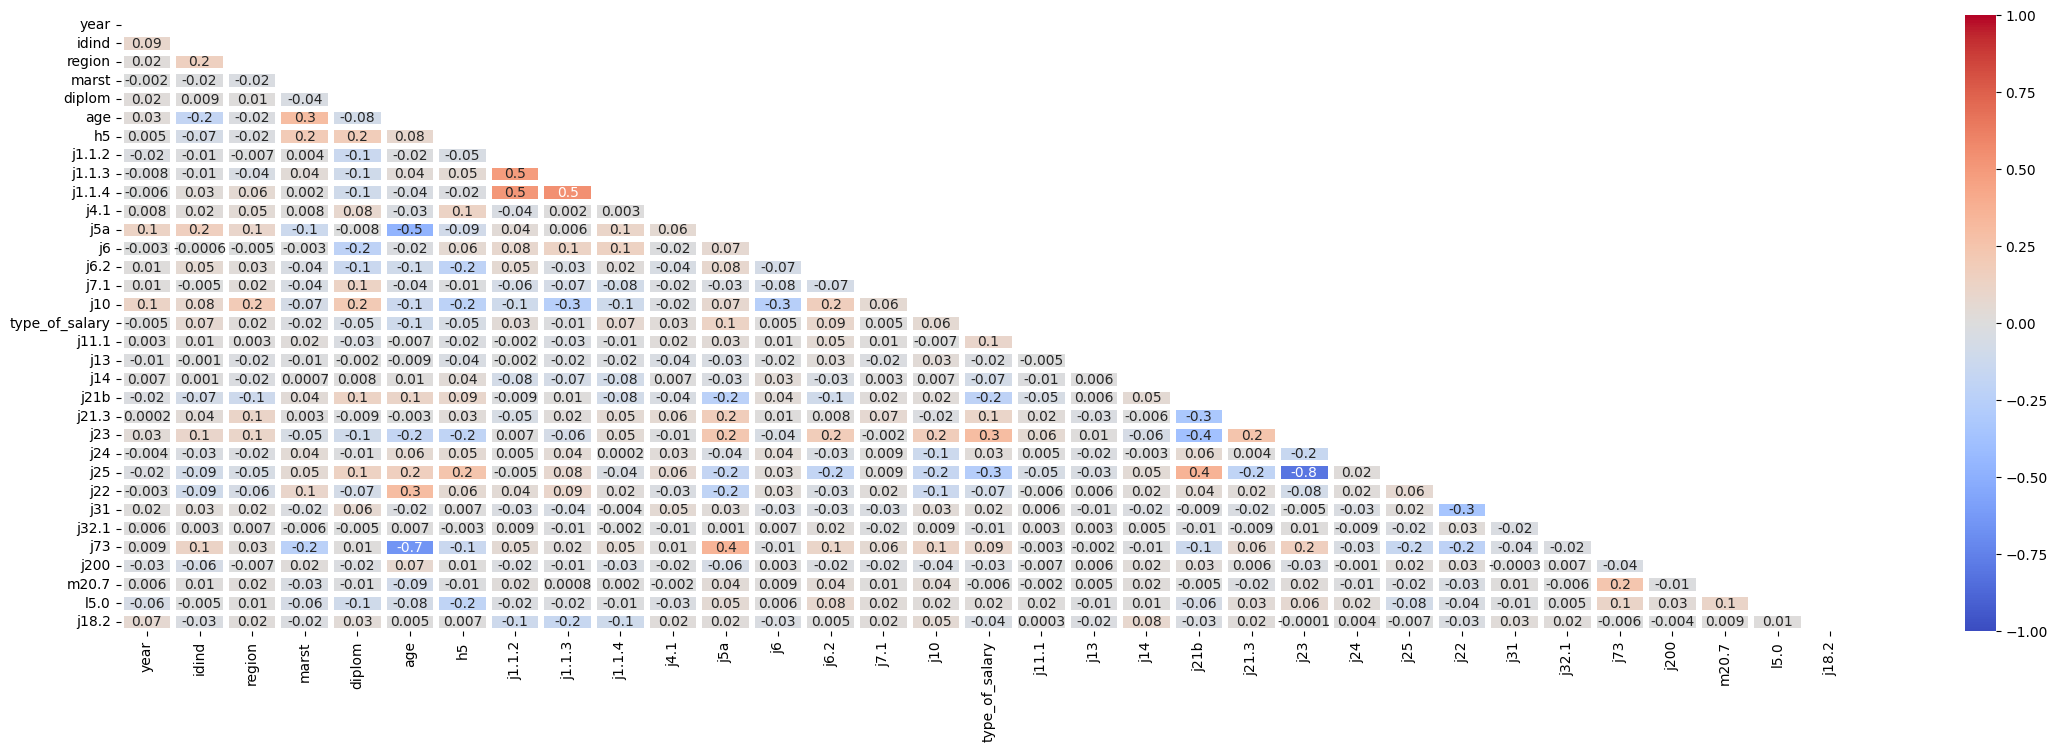

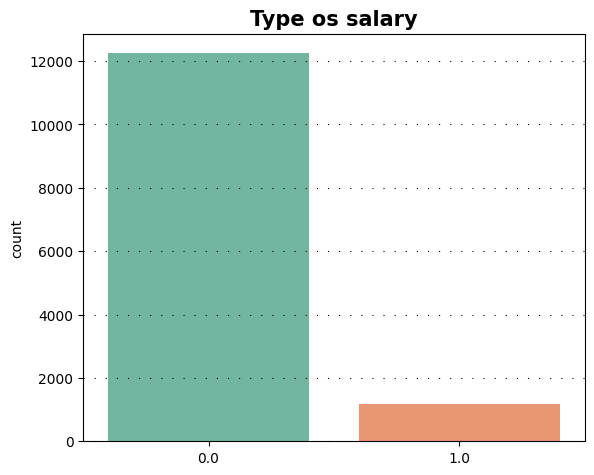

In [7]:
# Correlation matrix
plt.subplots(figsize=(28, 8))
matrix = np.triu(final_df.corr())
sns.heatmap(final_df.corr(), annot=True, vmin=-1, vmax=1, center= 0, fmt='.1g', 
            cmap= 'coolwarm', linewidths=3, mask=matrix)

fig = plt.figure(figsize=(22,18))
gs  = fig.add_gridspec(3,3)
ax1 = fig.add_subplot(gs[0,0])

# Distribution
leges = {1:'Official', 2:'Grey'}
ax1.set_title('Type os salary',fontweight ="bold",fontsize=15)
ax1.grid(color='#000000', linestyle='dashed', axis='y',dashes=(1,9))
sns.countplot(ax=ax1,data=final_df.assign(sex = final_df['type_of_salary'].replace(leges)),
              x='type_of_salary', palette = 'Set2')
ax1.set_xlabel("")

In [8]:
# Split on train and test
y = final_df.type_of_salary
X = final_df.drop('type_of_salary', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)
print('-'*11)
print(X_test.shape)

(10072, 32)
-----------
(3358, 32)


In [9]:
print(X_test.shape)
print(y_test.shape)

(3358, 32)
(3358,)


## Step_1: Catboots by default

In [10]:
%%time
pool = Pool(X_train, y_train, feature_names=list(X_train.columns))

catboost_default = CatBoostClassifier(iterations=5000).fit(pool, verbose = False)

catboost_predict_1 = catboost_default.predict(X_test)
print(classification_report(y_test, catboost_predict_1))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3048
         1.0       0.64      0.22      0.33       310

    accuracy                           0.92      3358
   macro avg       0.79      0.61      0.64      3358
weighted avg       0.90      0.92      0.90      3358

CPU times: user 34.5 s, sys: 21.6 s, total: 56.1 s
Wall time: 16.9 s


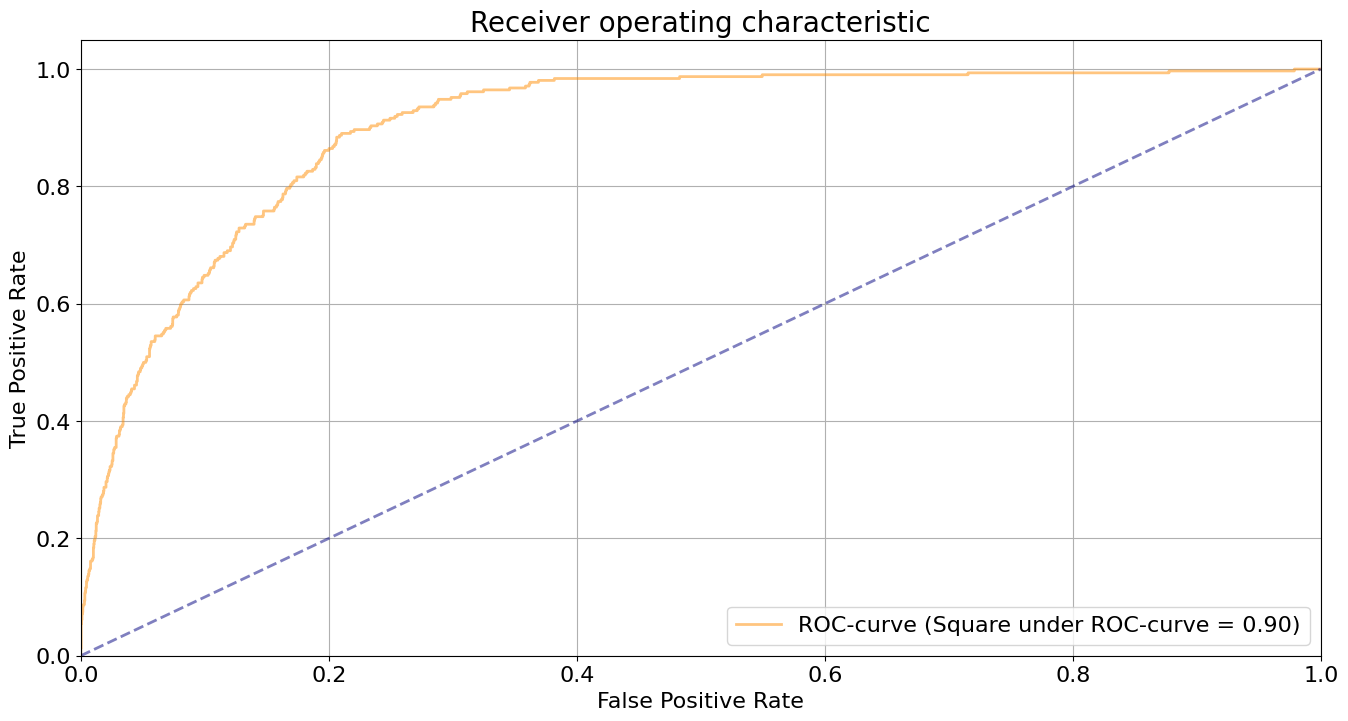

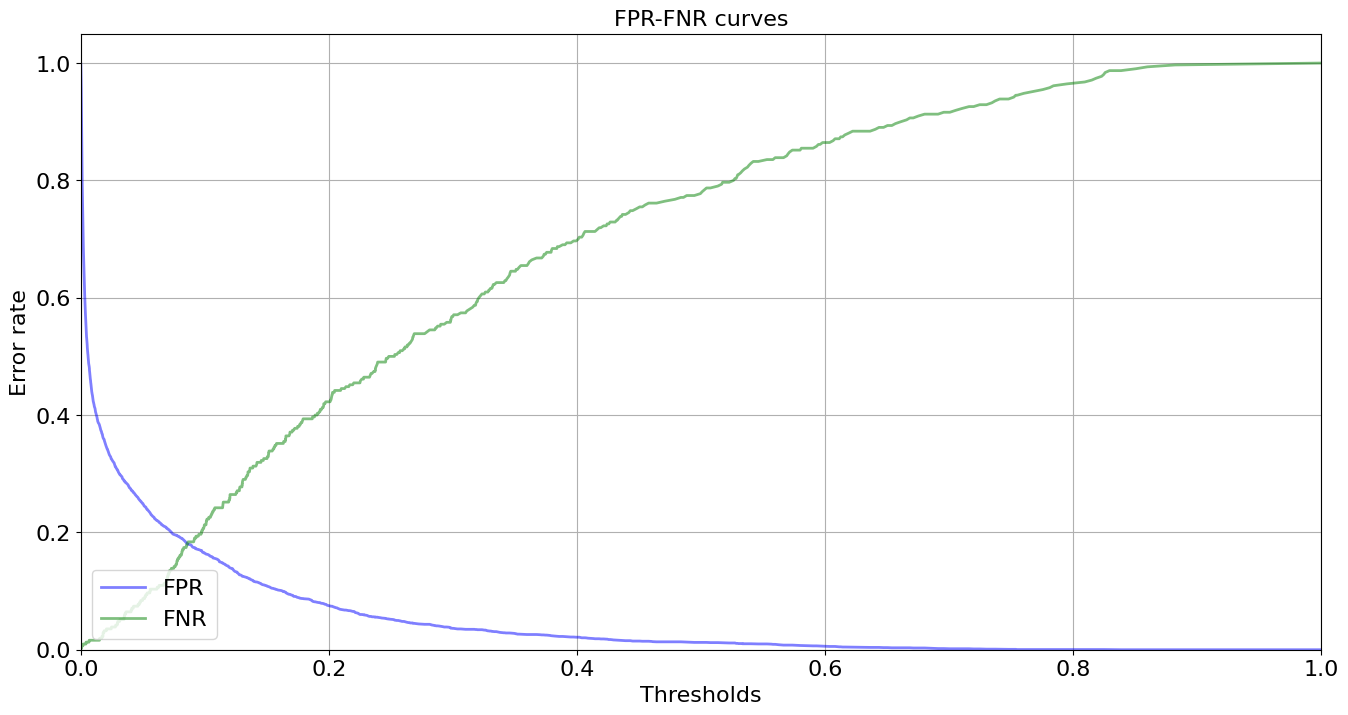

In [11]:
# AUC_curve
eval_pool = Pool(X_test, y_test)
curve = get_roc_curve(catboost_default, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC-curve (Square under ROC-curve = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Finding thresholds

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [12]:
catboost_default.set_probability_threshold(0.086)
catboost_predict_1 = catboost_default.predict(X_test)
print(classification_report(y_test, catboost_predict_1))

              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89      3048
         1.0       0.32      0.82      0.46       310

    accuracy                           0.82      3358
   macro avg       0.65      0.82      0.67      3358
weighted avg       0.92      0.82      0.85      3358



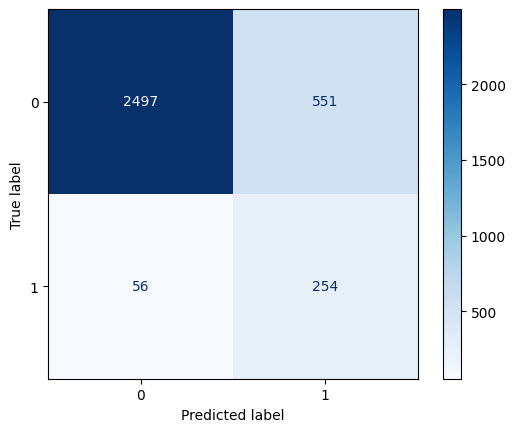

In [13]:
cm = confusion_matrix(y_test, catboost_predict_1)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## Step_2: Catboost with tuning

In [51]:
%%time
catboost_2 = CatBoostClassifier(random_seed=63,
                              iterations=5000,
                              learning_rate=0.04,
                              boosting_type='Plain', #Ordered or Plain
                              bootstrap_type='Bernoulli',
                              subsample=0.5,
                              rsm=0.5,
                              leaf_estimation_iterations=5,
                              max_ctr_complexity=1,
                              custom_loss=['AUC']).fit(pool, verbose = False)

CPU times: user 1min 21s, sys: 36.3 s, total: 1min 57s
Wall time: 26.5 s


In [52]:
# AUC_curve
eval_pool_2 = Pool(X_test, y_test)
curve = get_roc_curve(catboost_2, eval_pool_2)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC-curve (Square under ROC-curve = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Finding thresholds

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 2 should be feature with name age (found region).

In [ ]:
catboost_2.set_probability_threshold(0.017)
catboost_predict_2 = catboost_2.predict(X_test)
print(classification_report(y_test, catboost_predict_2))

cm = confusion_matrix(y_test, catboost_predict_2)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## Step_3: using only SMOTE

In [17]:
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [18]:
# Learning
catboost_3 = CatBoostClassifier(random_seed=63,
                              iterations=5000,
                              learning_rate=0.04,
                              boosting_type='Plain', #Ordered or Plain
                              bootstrap_type='Bernoulli',
                              subsample=0.5,
                              rsm=0.5,
                              leaf_estimation_iterations=5,
                              max_ctr_complexity=1,
                              custom_loss=['AUC']).fit(pool, verbose = False)

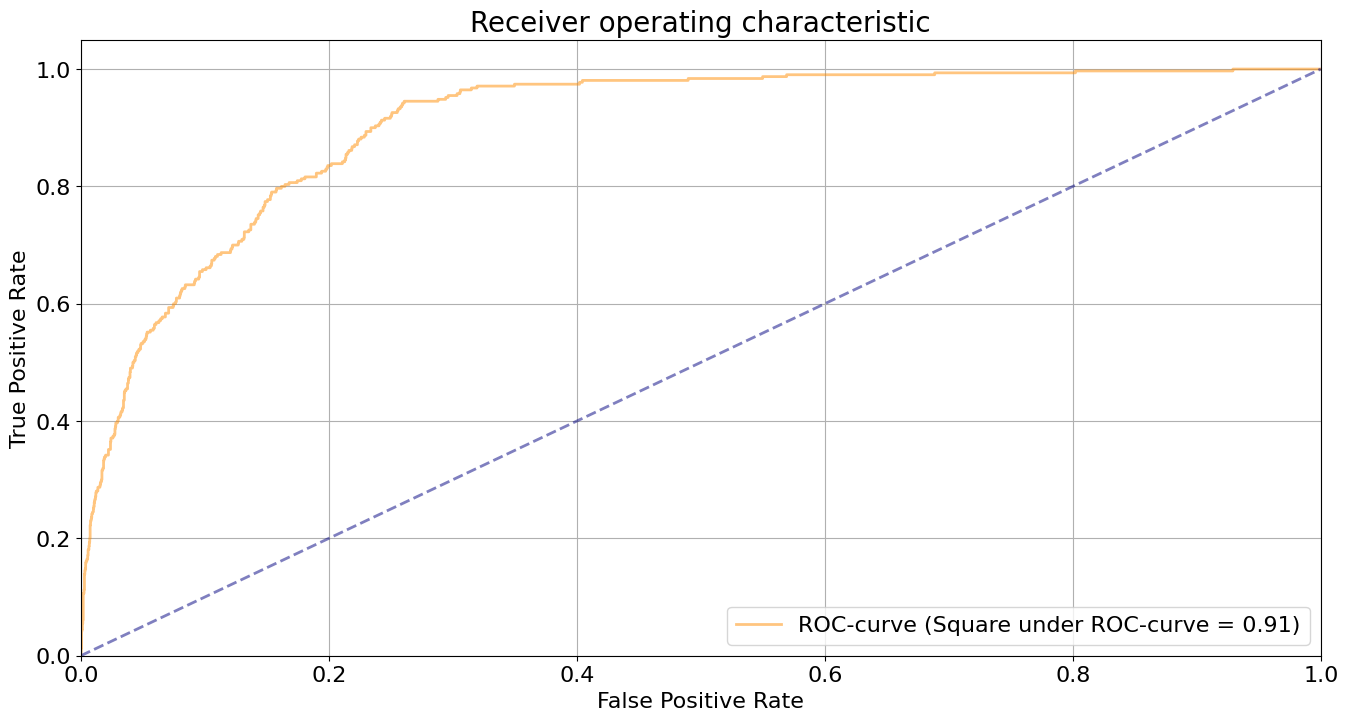

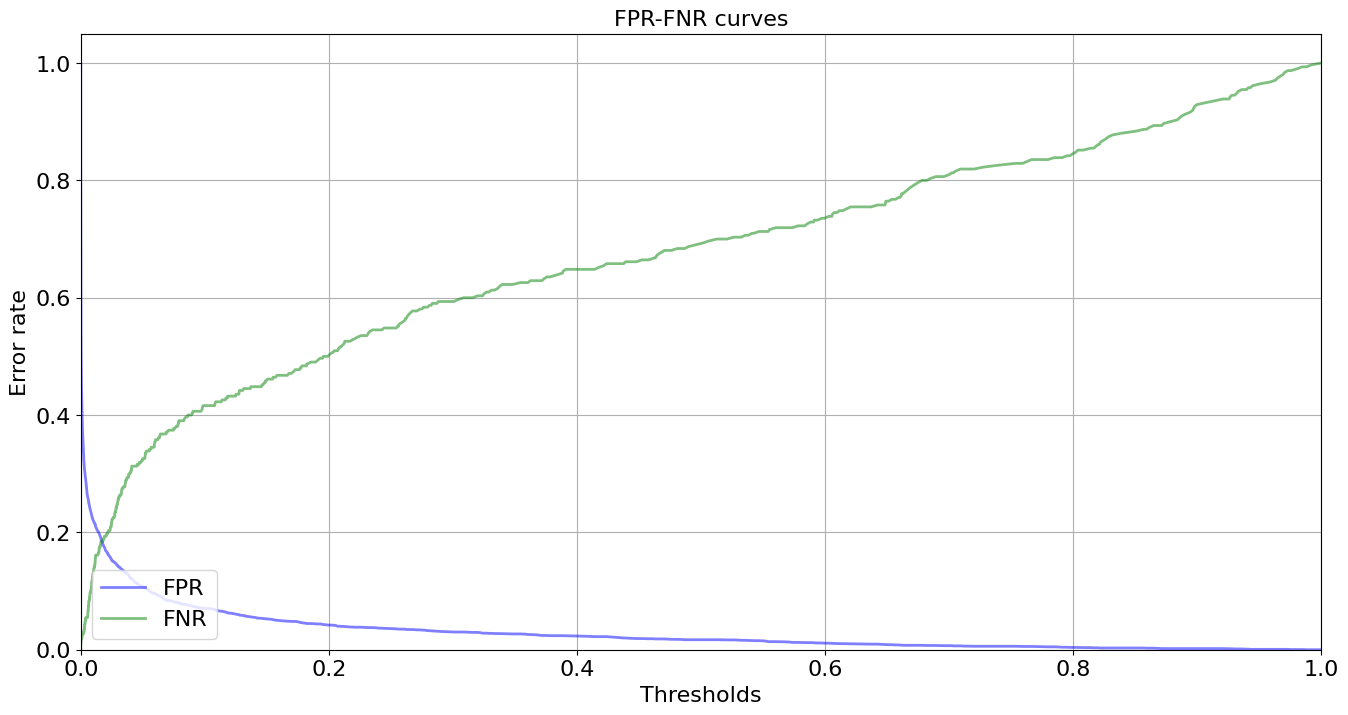

In [19]:
# AUC_curve
eval_pool_3 = Pool(X_test, y_test)
curve = get_roc_curve(catboost_3, eval_pool_3)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC-curve (Square under ROC-curve = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Finding thresholds

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      3048
         1.0       0.31      0.82      0.45       310

    accuracy                           0.82      3358
   macro avg       0.64      0.82      0.67      3358
weighted avg       0.92      0.82      0.85      3358



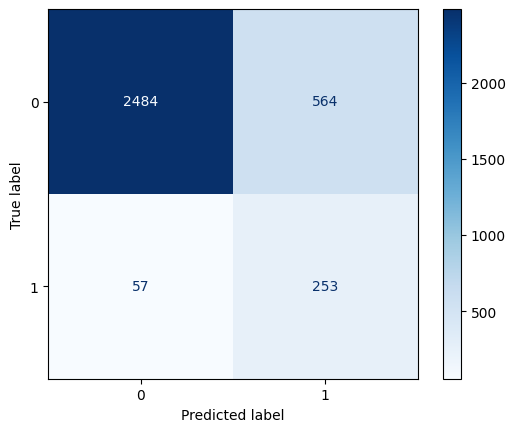

In [39]:
catboost_3.set_probability_threshold(0.017)
catboost_predict_3 = catboost_3.predict(X_test)
print(classification_report(y_test, catboost_predict_3))

cm = confusion_matrix(y_test, catboost_predict_3)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')

# Step_4: using one hot

In [21]:
# One Hot Encoding for train
categor_ohe_X_train = X_train[['region', 'diplom', 'h5', 'j4.1', 'marst']]
enc = OneHotEncoder()

enc.fit(categor_ohe_X_train)
codes = enc.transform(categor_ohe_X_train).toarray()
feature_names = enc.get_feature_names_out(categor_ohe_X_train.columns)
X_train_ = X_train.reset_index()
X_ohe = pd.DataFrame(codes, columns=feature_names).reset_index()
X_train_ohe = pd.concat([X_train_,
                        X_ohe], axis = 1)
X_train_ohe.drop(columns=['index', 'region', 'diplom', 'h5', 'j4.1', 'marst'], axis=1, inplace=True)

X_train_ohe.shape

(10072, 110)

In [22]:
# One Hot Encoding for test
categor_ohe_X_test = X_test[['region', 'diplom', 'h5', 'j4.1', 'marst']]

enc.fit(categor_ohe_X_test)
codes = enc.transform(categor_ohe_X_test).toarray()
feature_names = enc.get_feature_names_out(categor_ohe_X_test.columns)
X_test_ = X_test.reset_index()
X_ohe = pd.DataFrame(codes, columns=feature_names).reset_index()
X_test_ohe = pd.concat([X_test_,
                        X_ohe], axis = 1)
X_test_ohe.drop(columns=['index', 'region', 'diplom', 'h5', 'j4.1', 'marst'], axis=1, inplace=True)

X_test_ohe.shape

(3358, 110)

In [23]:
print(X_train_ohe.shape)
print(y_train.shape)

(10072, 110)
(10072,)


In [24]:
# SMOTE
sm = SMOTE()
X_train_ohe_sm, y_train_sm = sm.fit_resample(X_train_ohe, y_train)

In [25]:
X_train_sm.shape

(18414, 32)

In [26]:
y_train_sm.shape

(18414,)

In [30]:
pool = Pool(X_train_ohe_sm, y_train_sm, feature_names=list(X_train_ohe_sm.columns))

In [31]:
catboost_4 = CatBoostClassifier(random_seed=63,
                              iterations=5000,
                              learning_rate=0.05,
                              boosting_type='Plain', #Ordered or Plain
                              bootstrap_type='Bernoulli',
                              subsample=0.5,
                              rsm=0.5,
                              leaf_estimation_iterations=5,
                              max_ctr_complexity=1,
                              custom_loss=['AUC']).fit(pool, verbose = False)

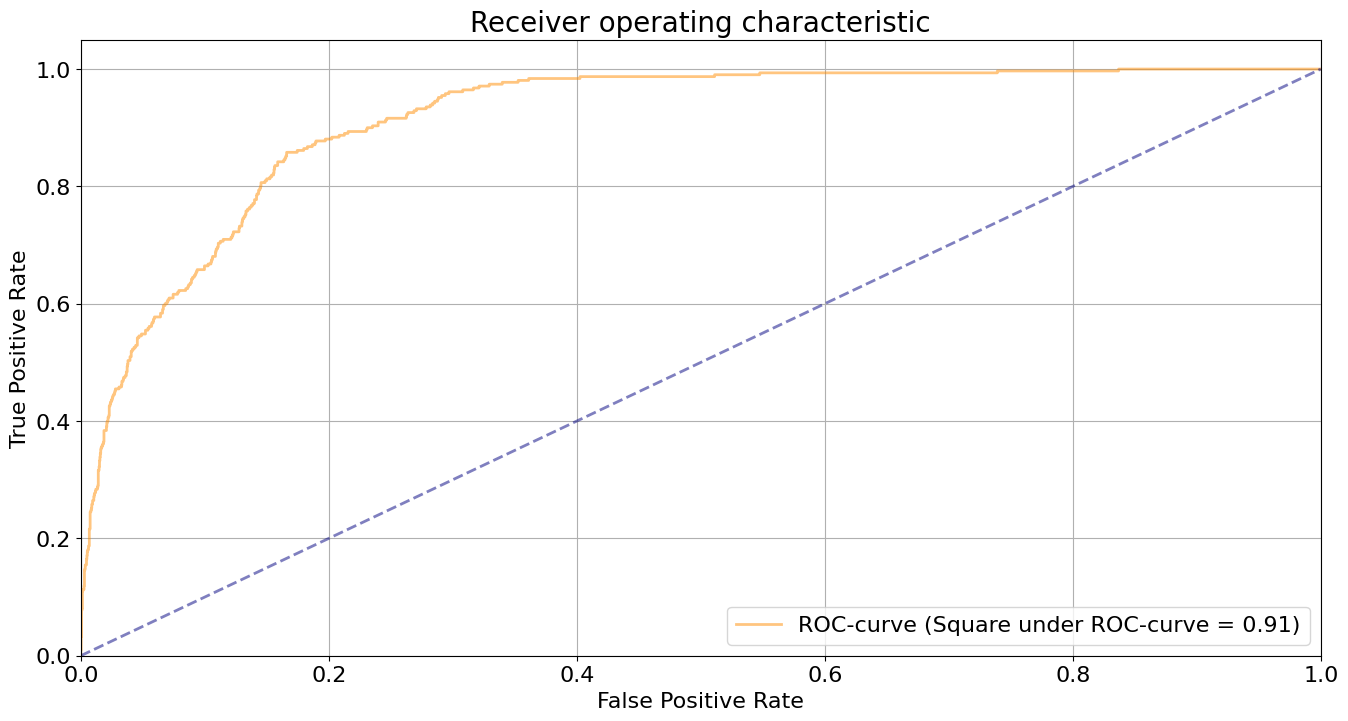

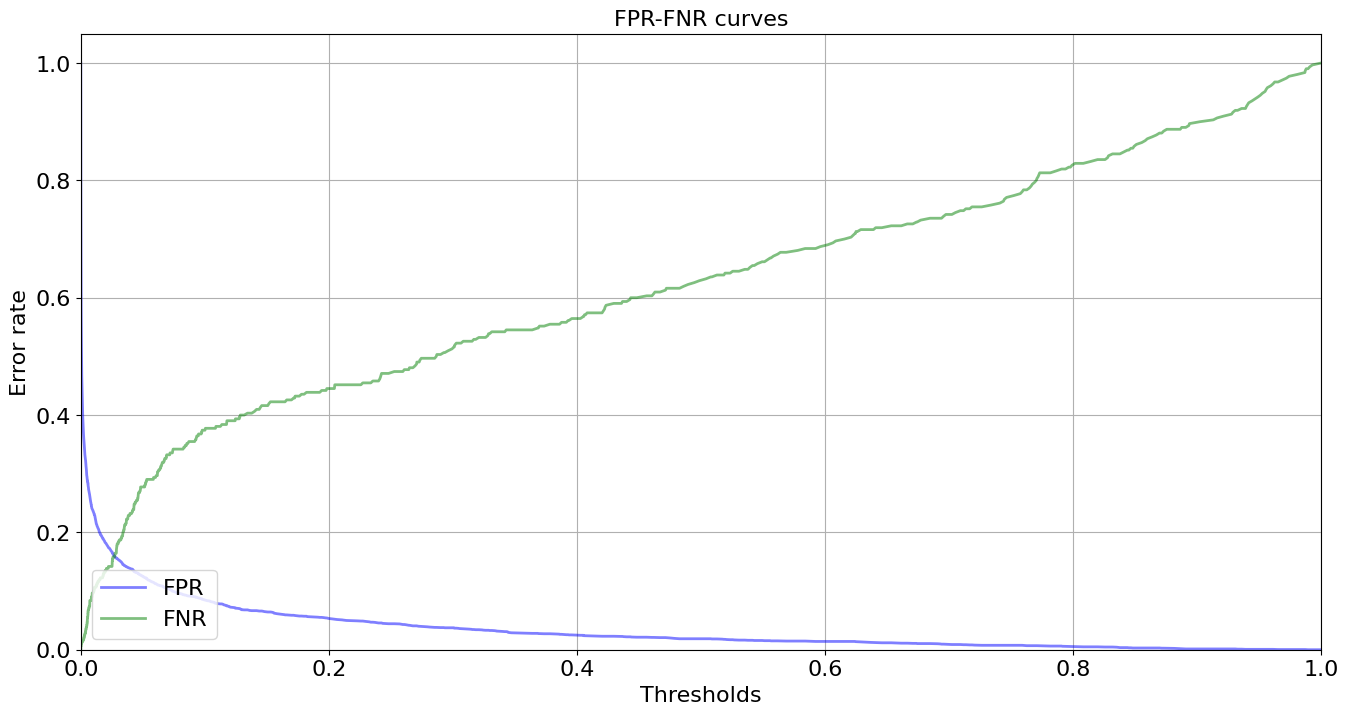

In [32]:
# AUC_curve
eval_pool_4 = Pool(X_test_ohe, y_test)
curve = get_roc_curve(catboost_4, eval_pool_4)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC-curve (Square under ROC-curve = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Finding thresholds

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

              precision    recall  f1-score   support

         0.0       0.98      0.84      0.91      3048
         1.0       0.35      0.84      0.49       310

    accuracy                           0.84      3358
   macro avg       0.67      0.84      0.70      3358
weighted avg       0.92      0.84      0.87      3358



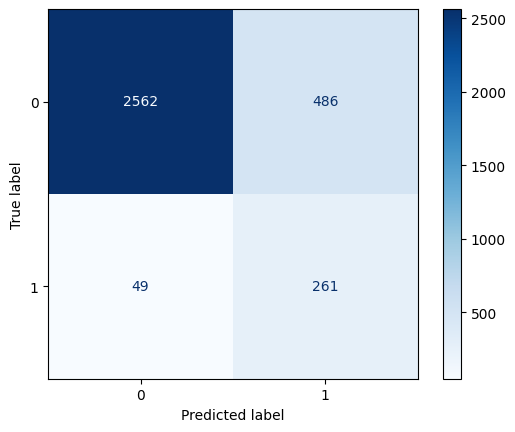

In [37]:
catboost_4.set_probability_threshold(0.027)
catboost_predict_4 = catboost_4.predict(X_test_ohe)
print(classification_report(y_test, catboost_predict_4))

cm = confusion_matrix(y_test, catboost_predict_4)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')

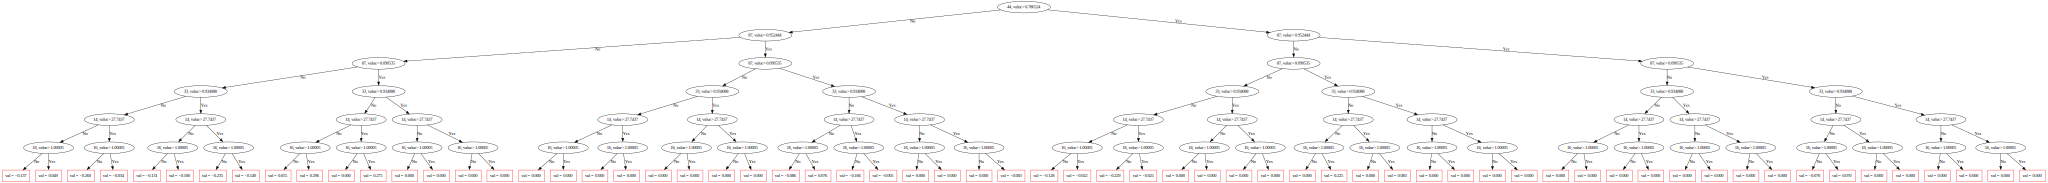

In [54]:
catboost_4.plot_tree(tree_idx=0, pool=None)

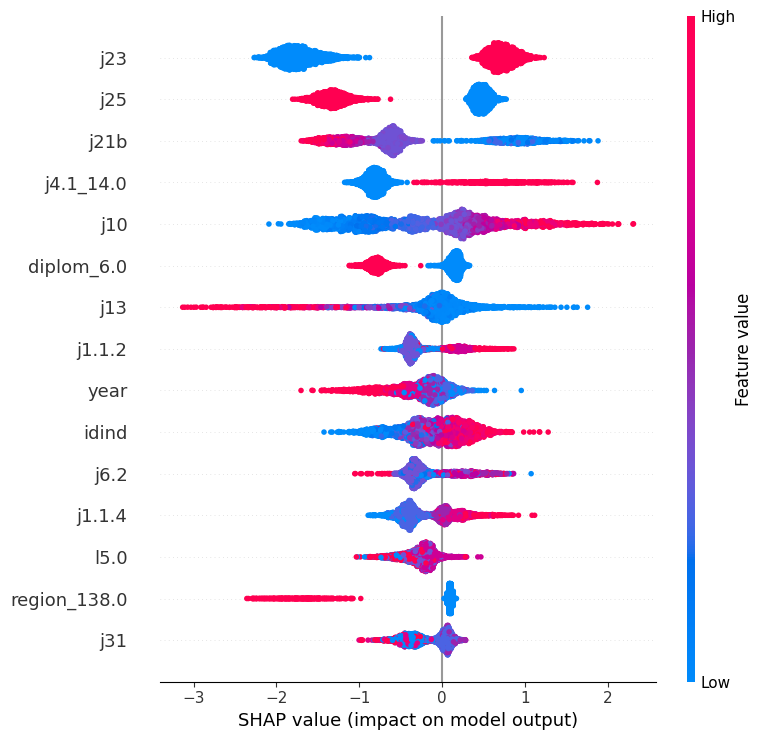

In [55]:
explainer = shap.TreeExplainer(catboost_4)
shap_values = explainer.shap_values(Pool(X_test_ohe, y_test))
shap.summary_plot(shap_values, X_test_ohe, max_display=15) #, max_display=10